# imports

In [1]:
import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

states = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
  "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
  "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
  "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
  "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
  "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]

assert len(states)==50

In [2]:


dbs = ['/media/hdd_1tb/data/'+fn for fn in os.listdir('/media/hdd_1tb/data/') if 'twitter' in fn and '.db' in fn]

us = pd.DataFrame(columns=['retweet_count', 'created_at', 'text', 'coordinates', 'user_loc',
       'user_lat', 'user_lon', 'user_loc_display', 'id', 'source', 'state'])

for db in dbs:
    conn = sqlite3.connect(db)
    df = pd.read_sql("SELECT * FROM covid19tweets WHERE instr(user_loc_display,'United States')>0",conn)
    conn.close()
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['state'] = None
    # assign state name to correct states
    # careful of Washington State vs D.C.
    for state in states:
        df.loc[
            (df['user_loc_display'].str.contains(state+', ') &
            ~df['user_loc_display'].str.contains('District of Columbia,')
            )
            ,'state'] = state
    
    us = pd.concat([us,df])
    

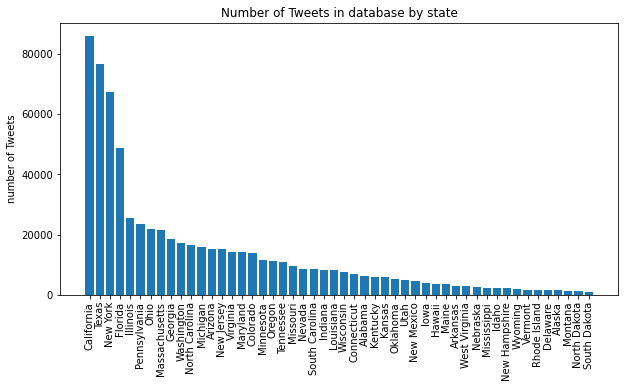

In [5]:
state_counts = us['state'].value_counts(normalize=False).sort_values(ascending=False)

# should be empty set if tweets available in all states
assert len(set(states) - set( state_counts.index.to_list()))==0

fig, ax = plt.subplots(figsize=(10,5))

ax.bar(state_counts.index, state_counts.values, align='center')
#ax.set_yticklabels(people)
ax.set_ylabel('number of Tweets')
ax.set_title('Number of Tweets in database by state')
plt.xticks(rotation=90)
plt.savefig('tweets_by_state.png',bbox_inches='tight')
plt.show()

In [33]:
us.sample(1)

,retweet_count,created_at,text,coordinates,user_loc,user_lat,user_lon,user_loc_display,id,source,state
282344,120,2020-06-12 11:23:42,RT @ItoniLl: Democrats cheering 'Black Lives M...,None,"Fort Smith, AR",35.3872218,-94.4248983,"Fort Smith, Sebastian County, Arkansas, United...",1271402792943583232,Twitter Web App,Arkansas


# flair sentiment

In [ ]:
import flair
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

In [20]:
s = flair.data.Sentence('You are a jerk.')
flair_sentiment.predict(s)

def flair_score(sentence):
    s = flair.data.Sentence(sentence)
    flair_sentiment.predict(s)
    
    if len(s.labels)>1:
        print('Flair should only return POSITIVE or NEGATIVE and not both.')
        print('s.to_plain_string: ',s.to_plain)
        print('s.labels:',s.to_plain_string)
    
    if s.labels[0].value=='NEGATIVE':
        return -1*s.labels[0].score
    elif s.labels[0].value=='POSITIVE':
        return s.labels[0].score
    else:
        print('Flair should only return one of POSITIVE or NEGATIVE.')
        print('s.to_plain_string: ',s.to_plain_string)
        print('s.labels:',s.labels)
        return None
        

0.7692387104034424

In [23]:
s.labels[0].value

'NEGATIVE'

In [25]:


for i,row in df.iterrows():
    df.at[i,'vader'] = analyser.polarity_scores(row['text'])['compound']

CPU times: user 11 ms, sys: 0 ns, total: 11 ms
Wall time: 10.2 ms


Sentence: "."   [− Tokens: 1  − Sentence-Labels: {'class': [POSITIVE (0.7597)]}]

In [11]:
total_sentiment[0].to_dict()

{'value': 'NEGATIVE', 'confidence': 0.7718008160591125}

In [7]:

# 300,000 rows takes < 2min

for i,row in df.iterrows():
    df.at[i,'vader'] = analyser.polarity_scores(row['text'])['compound']

In [9]:
df['vader'].mean()

0.008831013455777473

In [10]:
df['dayofyear'] = df['created_at'].dt.dayofyear

In [11]:
df_temp = df[['state','vader','dayofyear']].groupby(['state','dayofyear']).mean()
df_temp.head()

vader
state   dayofyear          
Alabama 82        -0.073073
        83        -0.023243
        84        -0.047744
        85        -0.087180
        86         0.004858

In [12]:
sentiment_by_day_and_state = df_temp.reset_index().pivot(index='state',columns='dayofyear',values='vader')
sentiment_by_day_and_state.head()

dayofyear,82,83,84,85,86,87,88,89,90,91,...,114,115,116,117,118,119,120,121,122,123
state,,,,,,,,,,,,,,,,,,,,,
Alabama,-0.073073,-0.023243,-0.047744,-0.087180,0.004858,-0.046045,0.081951,0.075813,0.085449,0.029838,...,0.027913,-0.083037,0.019396,-0.058651,-0.034285,0.080293,0.172740,0.010378,-0.039791,-0.035230
Alaska,-0.232850,-0.152890,-0.134654,0.152583,0.084063,0.039655,-0.042042,-0.020950,0.055680,0.250189,...,0.010800,-0.088078,0.021908,-0.008767,-0.050958,0.076069,-0.036444,0.218783,0.053400,0.001016
Arizona,0.076925,-0.099599,-0.038484,0.026690,-0.009538,0.035221,-0.048952,-0.043610,0.046395,-0.036607,...,0.074423,-0.070046,-0.005258,-0.098222,0.005666,-0.066954,0.034001,0.040436,-0.014060,-0.088452
Arkansas,-0.216517,-0.158397,-0.080700,-0.037306,-0.048212,-0.025555,0.004578,0.031528,-0.030426,0.015567,...,0.143457,-0.084233,-0.040854,-0.118789,0.030124,-0.022218,0.059587,0.123455,-0.019347,-0.190771
California,-0.020438,-0.044486,0.028085,-0.016810,-0.004629,0.049864,-0.005620,-0.032646,-0.009144,0.012077,...,0.045616,0.010779,0.048323,-0.076951,-0.013849,0.000586,0.009800,0.035965,0.012287,-0.052820


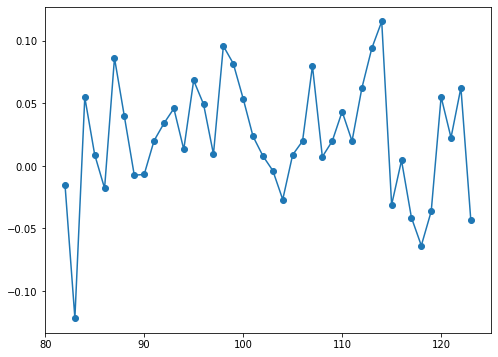

In [13]:
state = 'Michigan'


st_data = sentiment_by_day_and_state.loc[state]
st_data.values    

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(st_data.index, st_data.values,'o-',label=state)

# plotting covid twitter sentiment from top 8 states with most tweets

In [14]:
import datetime

def doy_to_date(dayofyear):
    return datetime.datetime.strptime('2020 '+str(dayofyear), '%Y %j').strftime('%b %d')

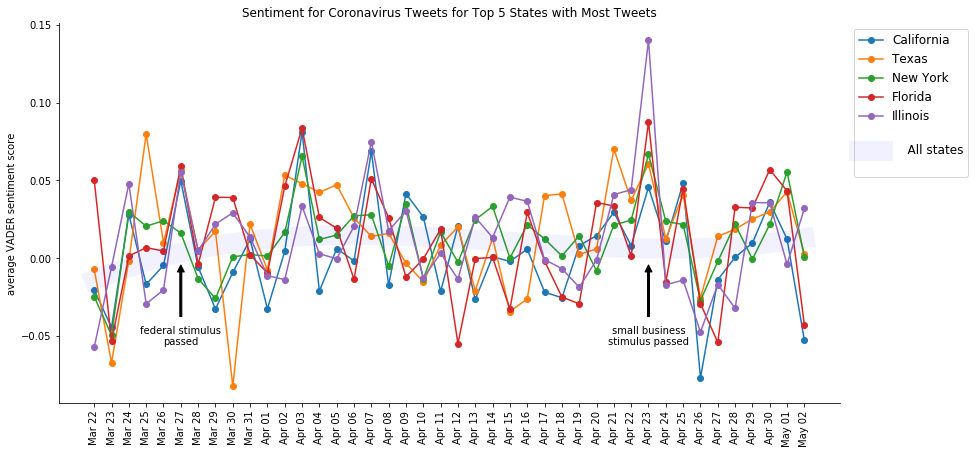

In [24]:
# plotting

from scipy.interpolate import UnivariateSpline
import numpy as np
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(figsize=(14, 7))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for state in state_counts.index[:5]:
    st_data = sentiment_by_day_and_state.loc[state]
    ax.plot(st_data.index, st_data.values,'o-',label=state)

overall = df[['dayofyear','vader']].groupby('dayofyear').mean()
spl = UnivariateSpline(overall.index, overall.values)
spl.set_smoothing_factor(0.05)
xs = np.linspace(min(overall.index),max(overall.index),100)
plt.plot(xs, spl(xs), 'b', lw=20,alpha=0.05,label='\n    All states\n')

ticks = list(sentiment_by_day_and_state.loc['Michigan'].index)


fontP = FontProperties()
fontP.set_size('large')
ax.legend(bbox_to_anchor=(1.01, 1),prop=fontP)

ax.annotate('federal stimulus\npassed', xy=(87, 0), xytext=(87, -0.05),
            arrowprops=dict(facecolor='black', width=2,headwidth=7,headlength=7,shrink=0.1),
            horizontalalignment='center',
            verticalalignment='center',
            
            )

ax.annotate('small business\nstimulus passed', xy=(114, 0), xytext=(114, -0.05),
            arrowprops=dict(facecolor='black', width=2,headwidth=7,headlength=7,shrink=0.1),
            horizontalalignment='center',
            verticalalignment='center',
            
            )


plt.xticks(ticks=ticks,labels = [doy_to_date(tick) for tick in ticks],rotation=90)
#plt.xlabel('day of year')
plt.ylabel('average VADER sentiment score')
plt.title('Sentiment for Coronavirus Tweets for Top 5 States with Most Tweets')



plt.show()



# sampling highest sentiment tweets

In [15]:
df[df['vader']>0.9]['text'].value_counts().nlargest(5)

RT @lsarsour: A Palestinian shoemaker started the West Bank’s only mask factory overnight. I love my people. So kind, so brilliant, so resi…            30
RT @radioheadfloyd: Never thought I’d say this but @BernieSanders sure seems like the most competent, adept and proactive candidate during…              9
RT @bamableu: This is the America I know &amp; love. \n\nHeroes volunteering to be on the front lines. \n\nThank you to all the brave souls who are…     8
RT @Cocofritz: .@GovAbbott HALTS ABORTION during #COVID19! I LOVE TX &amp; this governor! No one is exempt -- health &amp; safety for ALL! Those wh…     4
RT @MoveOn: .@staceyabrams said it best: we need immediate action to protect the health and safety of voters and the integrity of our elect…             3
Name: text, dtype: int64

In [18]:
nostate = df[df['state'].isnull()]
nostate.sample(5)

,retweet_count,created_at,text,coordinates,user_loc,user_lat,user_lon,user_loc_display,id,source,state,vader,dayofyear
34328,291,2020-03-26 21:49:54,RT @drdave1999: Trump strategically made testi...,None,USA,39.7837304,-100.4458825,United States,1243294128617684992,Twitter for iPhone,None,-0.1779,86
705,0,2020-03-22 04:44:48,Thanks for the information @strongways #covid1...,None,Washington DC,38.8948932,-77.0365529,"Washington, District of Columbia, 20500, Unite...",1241586604961128448,Twitter for iPhone,None,0.4404,82
37615,60689,2020-03-27 06:44:57,RT @protectheflames: My new favourite thing is...,None,USA,39.7837304,-100.4458825,United States,1243428777859801091,Twitter Web App,None,-0.7804,87
5435,34,2020-03-22 23:04:56,RT @DeedeeKIRO7: People NOT complying with soc...,None,"Washington, USA",38.8948932,-77.0365529,"Washington, District of Columbia, 20500, Unite...",1241863462994628609,Twitter for iPhone,None,0.0000,82
5381,20737,2020-03-22 22:54:47,RT @protectheflames: My new favourite thing is...,None,"Washington, DC",38.8948932,-77.0365529,"Washington, District of Columbia, 20500, Unite...",1241860908864999426,Twitter for iPhone,None,-0.7804,82
